In [1]:
!pip install pyspark

In [4]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("IplCricketAnalysis").getOrCreate()

# Load CSV file
file_path = "/content/batting.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the first few rows of the DataFrame
df.show(5)

# Print the schema to understand the structure of the data
df.printSchema()


+-------+---------+----+----------------+-----------------+-------------------+--------------------+----+-----+--------+----+----+------+-----+-----+----------+--------+-----------+-----------+
|MatchID|InningsNo|Team|      PlayerName|MatchPlayingOrder|         BowlerName|             OutDesc|Runs|Balls|DotBalls|Ones|Twos|Threes|Fours|Sixes|StrikeRate|WicketNo|AgainstFast|AgainstSpin|
+-------+---------+----+----------------+-----------------+-------------------+--------------------+----+-----+--------+----+----+------+-----+-----+----------+--------+-----------+-----------+
|      1|        1| CSK|Ruturaj  Gaikwad|                1|        Umesh Yadav|c Nitish Rana b U...|   0|    4|       4|   0|   0|     0|    0|    0|      0.00|     3.0|          3|          0|
|      1|        1| CSK|    Devon Conway|                2|        Umesh Yadav|c Shreyas Iyer b ...|   3|    8|       5|   3|   0|     0|    0|    0|     37.50|     2.0|          8|          0|
|      1|        1| CSK|   Rob

In [5]:
from pyspark.sql.functions import count, when, col
df.select([count(when(col(c).isNull(),c)).alias(c) for c in df.columns]).show()

+-------+---------+----+----------+-----------------+----------+-------+----+-----+--------+----+----+------+-----+-----+----------+--------+-----------+-----------+
|MatchID|InningsNo|Team|PlayerName|MatchPlayingOrder|BowlerName|OutDesc|Runs|Balls|DotBalls|Ones|Twos|Threes|Fours|Sixes|StrikeRate|WicketNo|AgainstFast|AgainstSpin|
+-------+---------+----+----------+-----------------+----------+-------+----+-----+--------+----+----+------+-----+-----+----------+--------+-----------+-----------+
|      0|        0|   0|         0|                0|       716|    452|   0|    0|       0|   0|   0|     0|    0|    0|         0|     717|          0|          0|
+-------+---------+----+----------+-----------------+----------+-------+----+-----+--------+----+----+------+-----+-----+----------+--------+-----------+-----------+



In [6]:
df_clean = df.dropna()
df_clean = df_clean.dropDuplicates()

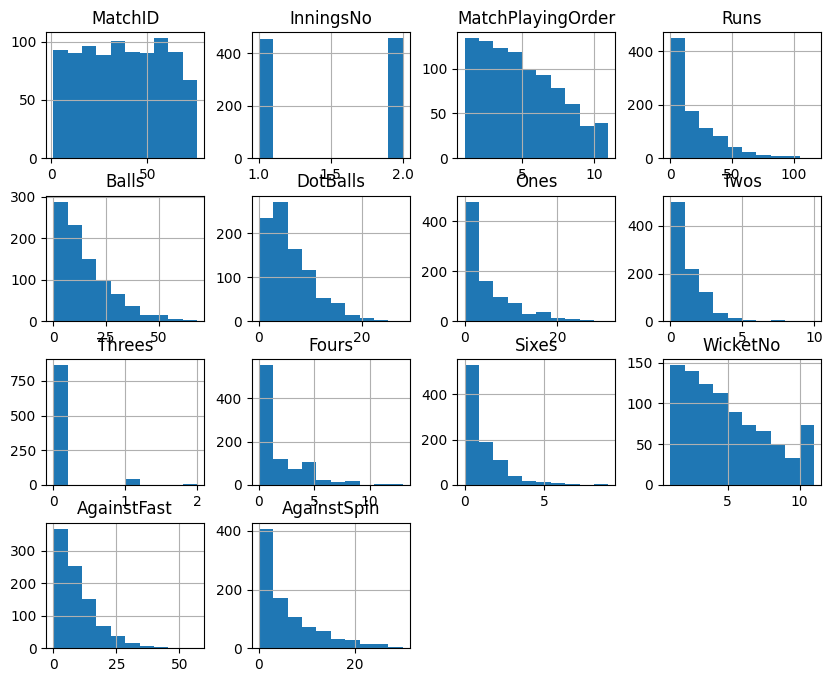

In [7]:
import matplotlib.pyplot as plt

pandas_df = df_clean.toPandas()

pandas_df.hist(figsize=(10,8))
plt.show()

In [10]:
avg_stats_bybatsman=df.groupBy('PlayerName').agg({ # Changed 'batsmanName' to 'PlayerName'
    'runs': 'avg',
    'balls': 'avg',
    'fours': 'avg',
    'sixes': 'avg',
    'strikeRate': 'avg'
    })
#Fixed: Corrected the variable name used in orderBy to match the assignment
avg_stats_by_batsman_sorted=avg_stats_bybatsman.orderBy('avg(runs)', ascending=False)

avg_stats_by_batsman_sorted.show(20)

+----------------+------------------+------------------+------------------+------------------+------------------+
|      PlayerName|        avg(sixes)|         avg(runs)|        avg(fours)|        avg(balls)|   avg(strikeRate)|
+----------------+------------------+------------------+------------------+------------------+------------------+
|     Jos Buttler|2.6470588235294117| 50.76470588235294| 4.882352941176471| 34.05882352941177|128.74882352941177|
|   Rajat Patidar|              2.25|            41.625|             3.375|             27.25|142.59142857142857|
|       K L Rahul|               2.0| 41.06666666666667|               3.0|30.333333333333332|101.88214285714285|
|Suryakumar Yadav|               2.0|            37.875|             2.875|              26.0|            138.74|
|    David Warner|              1.25|              36.0| 4.333333333333333|23.916666666666668|125.51833333333332|
|    Devon Conway|1.7142857142857142|              36.0| 3.142857142857143|24.7142857142

In [11]:
avg_sr_by_batsman = df.groupBy('PlayerName').agg({'strikeRate': 'avg'})
avg_stats_by_batsman_sorted = avg_sr_by_batsman.orderBy('avg(strikeRate)', ascending=False)
avg_stats_by_batsman_sorted.show(20)


+-----------------+------------------+
|       PlayerName|   avg(strikeRate)|
+-----------------+------------------+
|    Prerak Mankad|             400.0|
|      Ripal Patel|             200.0|
|        Tim David|194.09124999999997|
|       Avesh Khan|             185.0|
|   Shashank Singh|           174.208|
|      Manan Vohra|            172.73|
|   Dinesh Karthik|         172.53375|
|    Glenn Maxwell|168.69692307692307|
| Liam Livingstone|167.06571428571428|
|    Jitesh Sharma|           167.061|
|        Aman Khan|            166.67|
|   Jaydev Unadkat|           161.746|
|     Rishabh Pant|161.49153846153845|
|       Obed McCoy|             160.0|
|   Mahipal Lomror|           158.224|
|Bhanuka Rajapaksa| 153.9888888888889|
|    Rahul Tewatia|152.98333333333335|
|     Rishi Dhawan|          152.3875|
|     Chris Jordan|             150.0|
|     Sanju Samson|148.93529411764706|
+-----------------+------------------+
only showing top 20 rows



In [14]:
# Import necessary libraries
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

# Convert the 'SR' column to numeric type (float), replacing invalid values with None (NaN)
df_clean = df_clean.withColumn("strikeRate", col("strikeRate").cast("float"))

# Handle any NaN values (optional), for example by replacing NaN values with 0
df_clean = df_clean.na.fill({"strikeRate": 0})

# Feature Engineering: Combine relevant columns into a single feature vector
# Changed 'runs', 'balls', 'fours', 'sixes' to 'Runs', 'Balls', 'Fours', 'Sixes' to match the actual column names
assembler = VectorAssembler(
    inputCols=["Runs", "Balls", "Fours", "Sixes", "strikeRate"],  # Ensure these columns are numeric
    outputCol="features"
)

# Transform the dataset to include the features vector
data = assembler.transform(df_clean)

# Apply KMeans Clustering
kmeans = KMeans().setK(3).setSeed(1)  # Adjust the number of clusters as needed
model = kmeans.fit(data)

# Predict clusters and add them to the dataset
clusters = model.transform(data)

# Show the clustered results for relevant columns and predicted clusters
clusters.select("PlayerName", "Runs", "Balls", "Fours", "Sixes", "strikeRate", "prediction").show(20)

+---------------+----+-----+-----+-----+----------+----------+
|     PlayerName|Runs|Balls|Fours|Sixes|strikeRate|prediction|
+---------------+----+-----+-----+-----+----------+----------+
|   Rahul Chahar|  12|    8|    1|    1|     150.0|         0|
|      Moeen Ali|   1|    3|    0|    0|     33.33|         1|
|Shimron Hetmyer|   3|    7|    0|    0|     42.86|         1|
|    Shivam Dube|  32|   19|    2|    2|    168.42|         2|
|    Shivam Dube|  10|    9|    1|    0|    111.11|         0|
|   Deepak Hooda|  51|   33|    3|    3|    154.55|         2|
|   Deepak Hooda|  11|   13|    0|    0|     84.62|         0|
|  Hardik Pandya|  67|   49|    4|    2|    136.73|         0|
| Jonny Bairstow|  32|   28|    5|    0|    114.29|         0|
|   Deepak Hooda|  52|   34|    6|    1|    152.94|         2|
|   Sanju Samson|  13|   12|    2|    0|    108.33|         0|
| Faf Du Plessis|  96|   64|   11|    2|     150.0|         2|
|   Ishan Kishan|   0|    1|    0|    0|       0.0|    

In [15]:
df_clean.write.csv("db_batting.csv")